# Making stuff

In [ ]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import json
import collections
import itertools
from functools import partial

import numpy as onp
# from jax.config import config
# config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt

import numpy as onp
import jax
import pandas as pd
import haiku as hk
import ot

import config

import utils
import metrics
import time
import plot
import svgd
import stein
import kernels

from jax.experimental import optimizers

key = random.PRNGKey(0)

from jax.scipy.stats import norm

In [2]:
x = np.array(4.)
y = np.array(3.9)
z = np.nan

In [11]:
np.asarray([x, y, z])

DeviceArray([4. , 3.9, nan], dtype=float32)

# Interesting target dists

In [62]:
l = np.asarray((1, 2, 1.5, 3, 3.3, 3.8))
l = onp.concatenate([-l, [0], l])
means = list(zip(l, (l**2)**0.8))
variances = [[1,1]]*len(means)
weights = [1]*len(means)
target = metrics.GaussianMixture(means, variances, weights)

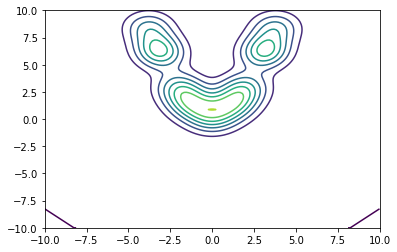

In [63]:
plot.plot_pdf(target.pdf, (-10, 10), "contour")

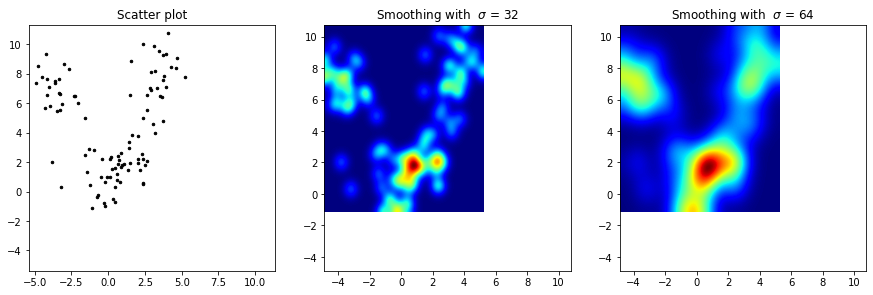

In [64]:
plot.bivariate_hist(target.sample(100))

# Test variance of KSD estimators
compare U-estimator with linear time estimator

In [2]:
target = metrics.Gaussian(0, 1)
source = metrics.Gaussian(0, 1)
kernel = kernels.ard(logh=0)

# estimate variance

In [3]:
L = 10 # linear time estimator uses L2n samples --> memory L2n, computation Ln, Var(KSD_L) = 1/Ln Var(h(X, Y))
      # where n = nr of samples for U-estimator

In [4]:
def sample_ksd(n, source, target, mode="l"):
    if mode=="u":
        samples = source.sample(n)
        return stein.ksd_squared_u(samples, target.logpdf, kernel)
    elif mode=="l":
        samples = source.sample(2*n).split(2)
        return stein.ksd_squared_l(*samples, target.logpdf, kernel, False)
    else:
        raise ValueError("mode must be 'u' or 'l'.")

# @partial(jit, static_argnums=range(5))
def sample_ksd_variance(n, m, source, target, mode="l"):
    return np.var(np.asarray([sample_ksd(n, source, target, mode) for _ in range(m)]))

In [5]:
m = 100
vars_u = []
vars_l = []
ngrid = 2**onp.arange(5, 10)

for n in ngrid:
    print(n)
    vars_u.append(sample_ksd_variance(n, m, source, target, "u"))
    vars_l.append(sample_ksd_variance(L*n, m, source, target, "l"))

32


/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


64
128
256
512


In [6]:
vars_u, vars_l = [np.asarray(x) for x in (vars_u, vars_l)] 

if not np.all(vars_l / vars_u < 1):
    print("Variance is too high!!")

Variance is too high!!


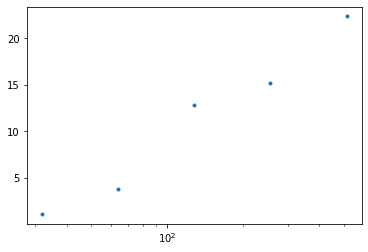

In [7]:
plt.plot(ngrid, vars_l / vars_u, ".")
plt.xscale("log")

In [8]:
vars_l

DeviceArray([0.00327123, 0.00190259, 0.0008834 , 0.00045037, 0.00022555],            dtype=float32)

In [9]:
vars_u

DeviceArray([2.9528379e-03, 5.0448021e-04, 6.8774068e-05, 2.9651657e-05,
             1.0113946e-05], dtype=float32)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


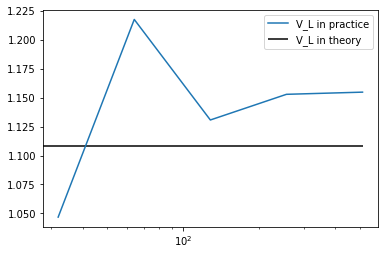

In [10]:
m = 1000000
samples = source.sample(m).split(2)
hvar = stein.h_var(*samples, target.logpdf, kernel)
hvar

plt.plot(ngrid, ngrid * L * vars_l, label="V_L in practice")
plt.hlines(hvar, xmin=0, xmax=ngrid[-1], label="V_L in theory")
# plt.yscale("log")
plt.xscale("log")
plt.legend()

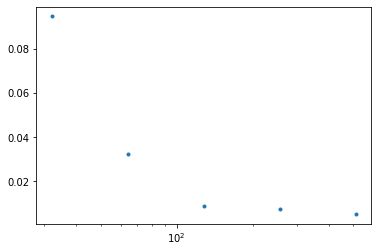

In [11]:
plt.plot(ngrid, ngrid * vars_u, ".")
plt.xscale("log")

# does jit cache intermediate computations, if useful?

Answer: yes! But: you don't get around memory constraints (e.g. three nested `vmap`s are always gonna need $n^3$ memory, even if output is a scalar).

In [12]:
def means(xs):
    compute = [np.mean(xs) for _ in range(100)], [np.mean(xs*2)/2 for _ in range(100)]
    return np.asarray(compute)
jitmeans = jit(means)
@jit
def single_mean(xs): return np.mean(xs)

In [13]:
times = []
jittimes = []
basetimes = []

grid = 2**np.arange(3)
for n in grid:
    key, subkey = random.split(key)
    xs = random.normal(subkey, (n,))
    
    time = %timeit -o means(xs).block_until_ready()
    jittime = %timeit -o jitmeans(xs).block_until_ready()
    base = %timeit -o single_mean(xs).block_until_ready()

    times.append(time.best)
    jittimes.append(jittime.best)
    basetimes.append(base.best)

98.1 ms ± 3.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
136 µs ± 35.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
95.4 µs ± 5.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
103 ms ± 4.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
170 µs ± 50.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
93.2 µs ± 2.47 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
95.6 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
147 µs ± 30.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
92.5 µs ± 995 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


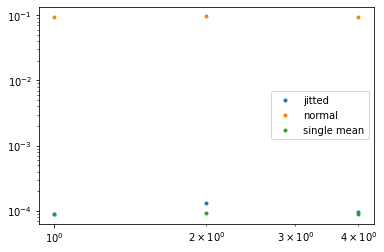

In [14]:
plt.plot(grid, jittimes, ".", label="jitted")
plt.plot(grid, times, ".", label="normal")
plt.plot(grid, basetimes, ".", label="single mean")

plt.xscale("log")
plt.yscale("log")
plt.legend()

In [15]:
slkfj

NameError: name 'slkfj' is not defined

In [ ]:
def test(x):
    n = 1000
    xs = np.repeat(x, n)
    idv = vmap(lambda x: x)
    idvv = vmap(idv)
    idvvv = vmap(idvv) now id takes argument of shape (n, n, n)
    return 

In [ ]:
# def h(x, y): return np.exp(np.sum((x - y)**2))
# def h_thrice(x, y, z): return h(x, y) * h(x, y) * h(y, z)
def h_thrice(x, y, z): return x+y+z


def test(xs):
    """In theory, to compute this it would suffice to compute x + y for all x, y in xs.
    Store those in an nxn matrix. """
    hv   = vmap(h_thrice, (0, None, None))
    hvv  = vmap(hv,       (None, 0, None))
    hvvv = vmap(hvv,      (None, None, 0))
    return np.mean(hvv(xs, xs, xs))

jittest = jit(test)

In [ ]:
n = 100
xs = random.normal(key, (n,))
test(xs)

In [ ]:
(2**11)**3 * 4 / 10**6

In [ ]:
(2**11)**2 * 4 / 10**6

In [ ]:
hk.data_structures.tree_bytes(xs)

In [ ]:
xs.shape

In [ ]:
times = []
jittimes = []

num_reps = 50
# grid = [3, 5, 10, 20, 50, 100, 200, 300]
grid = 2**np.arange(13)
for n in grid:
    key, subkey = random.split(key)
    xs = random.normal(subkey, (n,))
    
#     time = %timeit -o test(xs).block_until_ready()
    jittime = %timeit -o jittest(xs).block_until_ready()
    
#     times.append(time.best)
    jittimes.append(jittime.best)

In [ ]:
plt.plot(grid, jittimes, ".", label="jitted")
plt.plot(grid, times, ".", label="normal")
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [ ]:
sldfj

# more sampling stuff

In [ ]:
n = 10**2
key, subkey = random.split(key)
x = random.normal(subkey, (n,))

In [ ]:
normalization_factor = np.sum(norm.pdf(x))
weights = norm.pdf(x) / normalization_factor

In [ ]:
np.mean(x**2 * weights)

In [ ]:
np.mean(x**2)

## When is stuff zero?

In [ ]:
n = 10**6
key, subkey = random.split(key)
x = random.normal(subkey, (n,))

np.any(jax.scipy.stats.norm.pdf(x) == 0)